# OSNAP data extraction using NCO

In [1]:
%matplotlib inline
import cosima_cookbook as cc
import numpy as np
import pandas as pd
import xarray as xr
import flox  # for faster groupby in xarray with dask
from dask.distributed import Client
from datetime import timedelta, date
import calendar
import os
import shutil
import glob
from collections import OrderedDict
import subprocess
import warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)

In [2]:
import climtas.nci
climtas.nci.GadiClient(malloc_trim_threshold='64kib')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38967,Workers: 14
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:35321,Total threads: 1
Dashboard: /proxy/45199/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:33855,


In [3]:
session = cc.database.create_session()

## Initialise data structure and define helper functions

In [4]:
# WARNING! FORGETS ALL LOADED DATA!
data = OrderedDict() # init nested dict of experiments and their analyses

In [5]:
def addexpt(k, d):
    if k in data:
        print('skipped {}: already exists'.format(k))
    else:
        data[k] = d

In [6]:
def dictget(d, l):
    """
    Get item in nested dict using a list of keys

    d: nested dict
    l: list of keys
    """
    if len(l) == 1:
        return d[l[0]]
    return dictget(d[l[0]], l[1:])

In [7]:
def dictknown(d, l):
    """
    Return true if list of keys is valid in nested dict

    d: nested dict
    l: list of keys
    """    
    while len(l)>0 and l[0] in d:
        d = d[l[0]]
        l = l[1:]
    return len(l) == 0

In [8]:
def dictput(d, l, item):
    """
    Put item in nested dict using a list of keys

    d: nested dict
    l: list of keys
    item: item to be put
    """
    while l[0] in d and len(l)>1:  # transerse existing keys
        d = d[l[0]]
        l = l[1:]
    while len(l)>1:  # add new keys as needed
        d[l[0]] = dict()
        d = d[l[0]]
        l = l[1:]
    d[l[0]] = item
    return

In [9]:
# convenience functions
def dget(l):
    return dictget(data, l)
def dknown(l):
    return dictknown(data, l)
def dput(l, item):
    return dictput(data, l, item)

In [10]:
def showdata():
    """
    Display structure of data
    """
    for k, d in data.items():
        print(k)
        for k2, d2 in d.items():
            print('  ', k2)
            try:
                for k3, d3 in d2.items():
                    print('    ', k3)
                    try:
                        for k4, d4 in d3.items():
                            print('      ', k4)
                            try:
                                for k5, d5 in d4.items():
                                    print('        ', k5)
                                    try:
                                        for k6, d6 in d5.items():
                                            print('          ', k6)
                                    except:
                                        pass
                            except:
                                pass
                    except:
                        pass
            except:
                pass

## Set experiments, regions, date ranges, variables, frequencies etc
1deg_jra55_iaf_omip2_cycle6

1deg_jra55_iaf_omip2_cycle6_jra55v150_extension

025deg_jra55_iaf_omip2_cycle6

025deg_jra55_iaf_omip2_cycle6_jra55v150_extension

01deg_jra55v140_iaf_cycle4

01deg_jra55v140_iaf_cycle4_jra55v150_extension

In [11]:
addexpt('1', {'model':'access-om2',
              'expts': ['1deg_jra55_iaf_omip2_cycle6',
                        '1deg_jra55_iaf_omip2_cycle6_jra55v150_extension'],
              # 'gridpaths': ['/g/data/ik11/grids/ocean_grid_10.nc']
              'gridpaths': []
             })

In [12]:
addexpt('025', {'model':'access-om2-025',
                'expts': ['025deg_jra55_iaf_omip2_cycle6',
                          '025deg_jra55_iaf_omip2_cycle6_jra55v150_extension'],
                # 'gridpaths': ['/g/data/ik11/grids/ocean_grid_025.nc']
                'gridpaths': []
               })

In [13]:
addexpt('01', {'model':'access-om2-01',
               'expts': ['01deg_jra55v140_iaf_cycle4',
                         '01deg_jra55v140_iaf_cycle4_jra55v150_extension'],
               'gridpaths': [#'/g/data/ik11/grids/ocean_grid_01.nc', 
                             '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output000/ocean/ocean-2d-area_t.nc',
                             '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output000/ocean/ocean-2d-area_u.nc']
              })

In [14]:
showdata()

1
   model
   expts
   gridpaths
025
   model
   expts
   gridpaths
01
   model
   expts
   gridpaths


In [15]:
# set date range

tstart = pd.to_datetime('1958', format='%Y')
# tend = pd.to_datetime('2023-01-01', format='%Y-%m-%d')
tend = pd.to_datetime('2023', format='%Y')
# tend = tstart + pd.DateOffset(years=30)
timerange = slice(tstart, tend)
firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print('yearrange =', yearrange, 'complete years')
print('tstart =', tstart)
print('tend =', tend)

yearrange = 1958-2022 complete years
tstart = 1958-01-01 00:00:00
tend = 2023-01-01 00:00:00


In [16]:
varnames = [
            'u', 'v',
            'pot_temp',
            'salt',
            'pot_rho_0', 'pot_rho_2',
            'sea_level',
            'net_sfc_heating', 'frazil_3d_int_z',  # heat: https://forum.access-hive.org.au/t/net-surface-heat-and-freshwater-flux-variables/993/2
            'pme_river',  # water
            'sfc_salt_flux_ice', 'sfc_salt_flux_restore',  # salt
            # 'mh_flux',  # sea ice melt
            # 'sfc_hflux_coupler',
            # 'sfc_hflux_from_runoff',
            # 'sfc_hflux_pme',
            # 'net_sfc_heating', 'frazil_3d_int_z',  # Net surface heat flux into ocean is net_sfc_heating + frazil_3d_int_z: https://github.com/COSIMA/access-om2/issues/139#issuecomment-639278547
            # 'swflx',
            # 'lw_heat',
            # 'sens_heat',
            # 'evap_heat',
            # 'fprec_melt_heat',
           ]

In [17]:
tgriddims = ['xt_ocean', 'yt_ocean']
ugriddims = ['xu_ocean', 'yu_ocean']
tgridvars = ['geolon_t', 'geolat_t', 'area_t', 'dxt', 'dyt', 'ht']
ugridvars = ['geolon_c', 'geolat_c', 'area_u', 'dxu', 'dyu', 'hu']
gridvars = tgridvars+ugridvars+tgriddims+ugriddims

In [18]:
frequencies = ['1 monthly']

In [19]:
# for the North Atlantic: 70W-0E, 40N-70N
regions = OrderedDict([
    ('NA', {'lon': slice(-70, 0), 'lat': slice(40, 70)}),
])

## Calculations

### Load data

In [20]:
def loadalldata(data, regions, freqs, varnames, gridvars, timerange=timerange, ncfiles=None):
    region = 'global'
    reduction = 'unreduced'

    varnames = list(set(varnames))

    if not isinstance(ncfiles, list):
        ncfiles = [ncfiles]*len(varnames)  # use the same ncfile for all variables

    for expt in data.keys():
        print(expt)
        for freq in freqs:
            kkey = [expt, region, freq, reduction]
            for varname, ncfile in zip(varnames, ncfiles):
                if not dknown(kkey+[varname]):
                    if ncfile is None:
                        print('loading', varname)
                    else:
                        print('loading', varname, 'from', ncfile)
                    ds1 = cc.querying.getvar(dget([expt, 'expts'])[0], varname, session, frequency=freq, ncfile=ncfile, decode_coords=False, start_time=str(timerange.start))
                    ds2 = cc.querying.getvar(dget([expt, 'expts'])[1], varname, session, frequency=freq, ncfile=ncfile, decode_coords=False, end_time=str(timerange.stop))
                    dscombined = xr.concat([ds1, ds2], 'time').sel(time=timerange)
                    dscombined.attrs['ncfiles'] = ds1.attrs['ncfiles'] + ds2.attrs['ncfiles']
                    dscombined.attrs['description'] = [ds1.attrs['description'], ds2.attrs['description']]
                    try:
                        dscombined.attrs['notes'] = [ds1.attrs['notes'], ds2.attrs['notes']]
                    except KeyError:
                        pass
                    dput(kkey+[varname], dscombined)

        freq = 'static'

        # first look for grid data in gridpaths (to avoid NaNs)
        grids = [(p, xr.open_dataset(p, chunks='auto')) for p in dget([expt, 'gridpaths'])]
        for k in gridvars:
            kkey = [expt, region, freq, k]
            if not dknown(kkey):
                for (p, g) in grids:
                    try:
                        dput(kkey, g[k])
                        da = g[k]
                        print(k, 'loaded from', p)
                        break
                    except:
                        continue
                try:
                    da = da.rename({'grid_x_T': 'xt_ocean', 'grid_y_T': 'yt_ocean'}) # fix for 01deg
                    da.coords['xt_ocean'] = dget(kkey[0:-1]+['xt_ocean']).values
                    da.coords['yt_ocean'] = dget(kkey[0:-1]+['yt_ocean']).values
                    dput(kkey, da)
                except:
                    pass
                try:
                    da = da.rename({'grid_x_C': 'xu_ocean', 'grid_y_C': 'yu_ocean'}) # fix for 01deg
                    da.coords['xu_ocean'] = dget(kkey[0:-1]+['xu_ocean']).values
                    da.coords['yu_ocean'] = dget(kkey[0:-1]+['yu_ocean']).values
                    dput(kkey, da)
                except:
                    pass

        # then try to find any missing grid data via cookbook database (will have NaNs for land tiles)
        for k in gridvars:
            kkey = [expt, region, freq, k]
            if not dknown(kkey):
                try:
                    da = cc.querying.getvar(dget([expt, 'expts'])[0], k, session, frequency='static', decode_coords=False, n=1)
                    dput(kkey, da)
                    print(k, 'loaded from', da.attrs['ncfiles'][0])
                except:
                    pass

In [21]:
%%time
loadalldata(data, regions, frequencies, varnames, gridvars, timerange=timerange, ncfiles=None)

1
loading sea_level


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3

loading pot_rho_0


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 150. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "xt_ocean" starting at index 180. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 150. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3

loading v


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "xu_ocean" starting at index 180. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "yu_ocean" starting at index 150. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "xu_ocean" starting at index 180. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3

loading pot_temp
loading frazil_3d_int_z
loading u
loading pot_rho_2
loading salt
loading sfc_salt_flux_restore
loading sfc_salt_flux_ice
loading net_sfc_heating
loading pme_river
geolon_t loaded from /g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_grid.nc
geolat_t loaded from /g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_grid.nc
area_t loaded from /g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_grid.nc
dxt loaded from /g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_grid.nc
dyt loaded from /g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_grid.nc
ht loaded from /g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_grid.nc
geolon_c loaded from /g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_grid.nc
geolat_c loaded from /g/data/ik11/outputs/access-om2/1deg_jra

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 108. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "xt_ocean" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 108. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3

loading v


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "xu_ocean" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "yu_ocean" starting at index 108. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "xu_ocean" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3

loading pot_temp
loading frazil_3d_int_z
loading u
loading pot_rho_2
loading salt
loading sfc_salt_flux_restore
loading sfc_salt_flux_ice
loading net_sfc_heating
loading pme_river
geolon_t loaded from /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_grid.nc
geolat_t loaded from /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_grid.nc
area_t loaded from /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_grid.nc
dxt loaded from /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_grid.nc
dyt loaded from /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_grid.nc
ht loaded from /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_grid.nc
geolon_c loaded from /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_grid.nc
geolat_c loaded fro

In [22]:
dget(['1','global','static','dxt'])

<xarray.DataArray 'dxt' (yt_ocean: 300, xt_ocean: 360)>
dask.array<open_dataset-dxt, shape=(300, 360), dtype=float32, chunksize=(300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
Attributes:
    long_name:     ocean dxt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cyc...
    contact:       Hakase Hayashida
    email:         hakase.hayashida@utas.edu.au
    created:       2021-03-03
    description:   Cycle 6/6 of 1 degree ACCESS-OM2-BGC global configuration ...
    notes:         Output diagnostics are extensive based on the CMIP6 OMIP d...
    url:           https://github.com/hakaseh/1deg_jra55_iaf

In [23]:
dget(['01','global','static','dxt'])

<xarray.DataArray 'dxt' (yt_ocean: 2700, xt_ocean: 3600)>
dask.array<open_dataset-dxt, shape=(2700, 3600), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    long_name:     ocean dxt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2022-04-27
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Run configuration and history: https://github.com/COSIMA/0...

In [24]:
showdata()

1
   model
   expts
   gridpaths
   global
     1 monthly
       unreduced
         sea_level
         pot_rho_0
         v
         pot_temp
         frazil_3d_int_z
         u
         pot_rho_2
         salt
         sfc_salt_flux_restore
         sfc_salt_flux_ice
         net_sfc_heating
         pme_river
     static
       geolon_t
       geolat_t
       area_t
       dxt
       dyt
       ht
       geolon_c
       geolat_c
       area_u
       dxu
       dyu
       hu
       xt_ocean
       yt_ocean
       xu_ocean
       yu_ocean
025
   model
   expts
   gridpaths
   global
     1 monthly
       unreduced
         sea_level
         pot_rho_0
         v
         pot_temp
         frazil_3d_int_z
         u
         pot_rho_2
         salt
         sfc_salt_flux_restore
         sfc_salt_flux_ice
         net_sfc_heating
         pme_river
     static
       geolon_t
       geolat_t
       area_t
       dxt
       dyt
       ht
       geolon_c
       geolat_c
       area_u
    

## Calculating dzt, dzu

These are the same (equal to diff of `st_edges_ocean`) except in the bottom partial cells.

In [47]:
basedir = '/g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-new/'

In [45]:
%%time
freq = 'static'
for expt in data.keys():
    print(expt)
    for varname in ['dzt', 'dzu']:
        for region, region_data in regions.items():
            gvardir = os.path.join(basedir, 'global', freq, expt).replace(' ', '_')
            gvarf = os.path.join(gvardir, '-'.join(['access-om2', expt, varname])+'.nc')
            os.makedirs(gvardir, exist_ok=True)

            vardir = os.path.join(basedir, region, freq, expt).replace(' ', '_')
            varf = os.path.join(vardir, '-'.join(['access-om2', expt, varname])+'.nc')
            os.makedirs(vardir, exist_ok=True)
            
            st_ocean = dget([expt,'global','1 monthly','unreduced','salt']).st_ocean
            st_edges_ocean = cc.querying.getvar(dget([expt, 'expts'])[0], 'st_edges_ocean', session, frequency='1 monthly', n=1)
            
            dzt_1d = st_edges_ocean.diff('st_edges_ocean').assign_coords(st_edges_ocean=st_ocean.data).rename({'st_edges_ocean': 'st_ocean'})

            if varname == 'dzt':
                dzt = 0*dget([expt,'global','1 monthly','unreduced','salt']).isel(time=0) + dzt_1d
                
                kmt = cc.querying.getvar(dget([expt, 'expts'])[0], 'kmt', session, frequency='static', n=1).round().astype('int64')
                kmt = xr.where(kmt<0, 1, kmt).compute() - 1  # -1 to use zero-based indexing
    
                ht = dget([expt,'global','static','ht'])
                dzt_bottom = ht - st_edges_ocean[kmt]
    
            elif varname == 'dzu':  # (confusingly) keep same variable names as for t cells
                dzt = 0*dget([expt,'global','1 monthly','unreduced','u']).isel(time=0) + dzt_1d
                
                kmt = cc.querying.getvar(dget([expt, 'expts'])[0], 'kmu', session, frequency='static', n=1).round().astype('int64')
                kmt = xr.where(kmt<0, 1, kmt).compute() - 1  # -1 to use zero-based indexing
    
                ht = dget([expt,'global','static','hu'])
                dzt_bottom = ht - st_edges_ocean[kmt]
            else:
                raise ValueError('Bad varname: '+varname)

            dzt_fixed = xr.where(dzt.st_ocean==dzt.st_ocean[kmt],
                     dzt_bottom, # put partial cell height in bottom cells
                     dzt).rename(varname)

            gds = dzt_fixed

# output global grid data
            if os.path.exists(gvarf):
                print('--- skipped existing', gvarf)
                pass
            else:
                print('saving', gvarf)
                for k in tgridvars+ugridvars+['st_edges_ocean']:  # drop extraneous coords
                    try:
                        gds = gds.drop_vars(k)
                    except ValueError:
                        pass
                gds.to_netcdf(gvarf+'-PARTIAL')
                os.rename(gvarf+'-PARTIAL', gvarf)

# extract spatial regions
            lons = ','.join([gds.dims[-1],
                                   repr(float(region_data['lon'].start)),
                                   repr(float(region_data['lon'].stop))])
            lats = ','.join([gds.dims[-2],
                                   repr(float(region_data['lat'].start)),
                                   repr(float(region_data['lat'].stop))])
            if os.path.exists(varf):
                print('--- skipped existing', varf)
                pass
            else:
                cmd = ['ncks', '-v', varname, '-d', lons, '-d', lats, '-O', gvarf, varf]
                print(' '.join(cmd))
                proc = subprocess.run(cmd)

1
saving /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-CHUCKABLE/global/static/1/access-om2-1-dzt.nc
ncks -v dzt -d xt_ocean,-70.0,0.0 -d yt_ocean,40.0,70.0 -O /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-CHUCKABLE/global/static/1/access-om2-1-dzt.nc /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-CHUCKABLE/NA/static/1/access-om2-1-dzt.nc
saving /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-CHUCKABLE/global/static/1/access-om2-1-dzu.nc
ncks -v dzu -d xu_ocean,-70.0,0.0 -d yu_ocean,40.0,70.0 -O /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-CHUCKABLE/global/static/1/access-om2-1-dzu.nc /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-CHUCKABLE/NA/static/1/access-om2-1-dzu.nc
025
saving /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-CHUCKABLE/global/static/025/access-om2-025-dzt.nc
ncks -v dzt -d xt_ocean,-70.0,0.0 -d yt_ocean,40.0,70.0 -O /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-CHUCKABLE/glob

# TODO: check if `[xy][tu]_ocean` is consistent between grid vars and coords - or have they got the wrong values from gridpaths? See cell above.

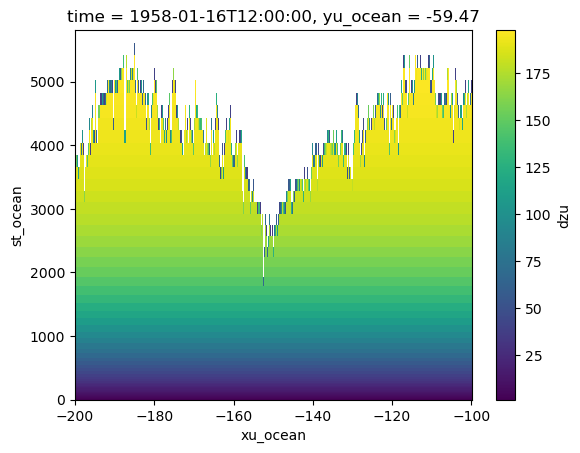

In [49]:
dzt_fixed.isel(yu_ocean=500).sel(xu_ocean=slice(-200,-100)).plot()

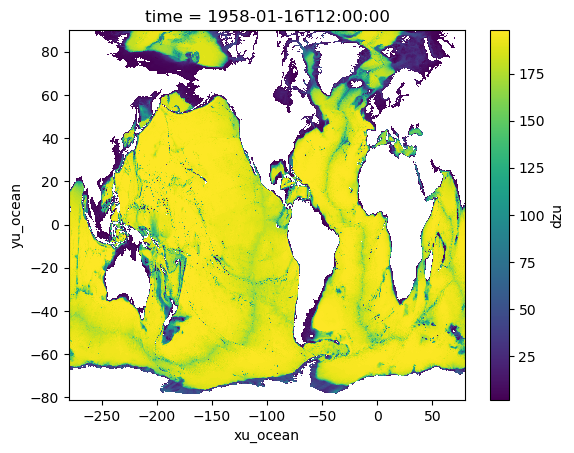

In [50]:
dzt_fixed.isel(st_ocean=kmt-1).plot()

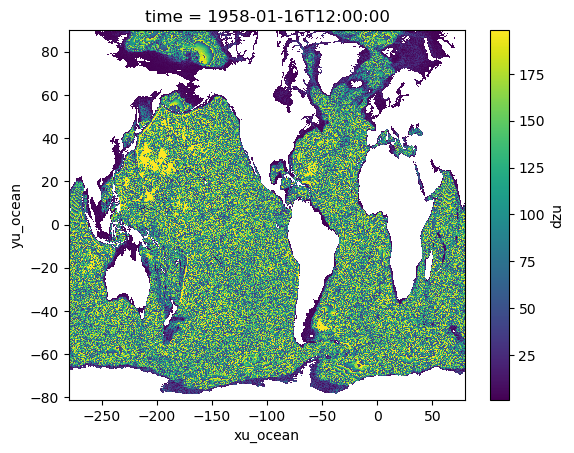

In [51]:
dzt_fixed.isel(st_ocean=kmt).plot()

## Get filenames to use with nco

#### Regional subsetting:
- https://nco.sourceforge.net/nco.html#ncks-netCDF-Kitchen-Sink
```
ncks -d xu_ocean,-70.0,0.0 -d yu_ocean,40.0,70.0 in.nc out.nc
```
takes ~7sec per 1-month file at 0.1°

Get in.nc from `dget(['01','global','1 monthly','unreduced','u']).attrs['ncfiles']`

#### Concatenation in time:
- https://nco.sourceforge.net/nco.html#Concatenation
- https://nco.sourceforge.net/nco.html#ncrcat-netCDF-Record-Concatenator
```
ncrcat in1.nc in2.nc ... inN.nc out.nc
```
NB: inputs must be in chronological order!

#### Trim in time:
- https://nco.sourceforge.net/nco.html#Hyperslabs

`ncfiles` list may contain more files than we need, so trim in time with `ncks`. Negative integer indices are offsets from the end, e.g. `-d time,,-2` drops the final time slice.

- `for f in access-om2-1* ; do echo $f; ncdump -t -v time $f | grep 202[34]-; done` shows the 1deg data is already OK

- `for f in access-om2-025* ; do echo $f; ncdump -t -v time $f | grep 202[34]-; done` shows 4 extra time slices in 0.25deg, so use `ncks -d time,,-5 in.nc out.nc` to trim them
```
    "2023-01-14 12", "2023-02-13", "2023-03-14 12", "2023-04-14" ;
```

- `for f in access-om2-01* ; do echo $f; ncdump -t -v time $f | grep 202[34]-; done` shows 1 extra time slice in 0.1deg, so use `ncks -d time,,-2 in.nc out.nc` to trim them
```
    "2023-01-16 12" ;
```

In [ ]:
%%time
# extract and concatenate data for each region using nco
reduction = 'unreduced'
for expt in data.keys():
    for region, region_data in regions.items():
        for freq in frequencies:
            kkey = [expt, region, freq, reduction]
            for varname, vardata in dget([expt, 'global', freq, reduction]).items():
                vardir = os.path.join(basedir, region, freq, expt, varname).replace(' ', '_')
                os.makedirs(vardir, exist_ok=True)

                # extract spatial regions
                lons = ','.join([vardata.dims[-1],
                                       repr(float(region_data['lon'].start)),
                                       repr(float(region_data['lon'].stop))])
                lats = ','.join([vardata.dims[-2],
                                       repr(float(region_data['lat'].start)),
                                       repr(float(region_data['lat'].stop))])
                for count, nc in enumerate(vardata.attrs['ncfiles']):
                    if expt == '01':
                        outf = os.path.join(vardir, os.path.basename(nc))
                    else:
                        outf = os.path.join(vardir, '-'.join([varname, f'{count:04}']))
                    if os.path.exists(outf):
                        # print('--- skipped existing', outf)
                        pass
                    else:
                        # cmd = ['ncks', '-d', lons, '-d', lats, nc, outf] # TODO: -v varname
                        cmd = ['ncks', '-v', varname, '-d', lons, '-d', lats, nc, outf]
                        # print(' '.join(cmd))
                        proc = subprocess.run(cmd)
    #                     break
                
                # concatenate in time
                outf = os.path.join(basedir, '-'.join(['access-om2', expt, varname])+'.nc')
                if os.path.exists(outf):
                    print('--- skipped existing', outf)
                    
                else:
                    print(outf)
                    infiles = sorted(glob.glob(os.path.join(vardir, '*'))) #.sort()
                    cmd = ['ncrcat', *infiles, outf]
                    # print(' '.join(cmd))
                    proc = subprocess.run(cmd)
                    # break
                # break

                # trim in time
                tvardir = os.path.join(basedir, 'trimmed', '-'.join(['access-om2', expt]))
                os.makedirs(tvardir, exist_ok=True)
                toutf = os.path.join(tvardir, os.path.basename(outf))
                
                if os.path.exists(toutf):
                    print('--- skipped existing', toutf)
                else:
                    if expt == '01':
                        idx = -2
                    elif expt == '025':
                        idx = -5
                    else:
                        idx = None
    
                    if idx:
                        cmd = ['ncks', '-d', 'time,,'+str(idx), outf, toutf]
                        print(' '.join(cmd))
                        proc = subprocess.run(cmd)
                    else:
                        print('shutil.copy2({}, {})'.format(outf, toutf))
                        shutil.copy2(outf, toutf)
                    # break
    # break

now check with
```
for f in trimmed/*/* ; do echo $f; ncdump -t -v time $f | grep 202[2-4]-; done
```
and copy to globus with
```
rsync -vrltoD data-nco/trimmed/* /g/data/ik11/globus/osnap-access-om2
```

In [52]:
%%time
freq = 'static'
for expt in data.keys():
    for varname in tgridvars+ugridvars:
        for region, region_data in regions.items():
            gvardir = os.path.join(basedir, 'global', freq, expt).replace(' ', '_')
            gvarf = os.path.join(gvardir, '-'.join(['access-om2', expt, varname])+'.nc')
            os.makedirs(gvardir, exist_ok=True)
        
            vardir = os.path.join(basedir, region, freq, expt).replace(' ', '_')
            varf = os.path.join(vardir, '-'.join(['access-om2', expt, varname])+'.nc')
            os.makedirs(vardir, exist_ok=True)

            gds = dget([expt, 'global', freq, varname])

# output global grid data
            if os.path.exists(gvarf):
                print('--- skipped existing', gvarf)
                pass
            else:
                print('saving', gvarf)
                for k in tgridvars+ugridvars:  # drop extraneous coords
                    try:
                        gds = gds.drop_vars(k)
                    except ValueError:
                        pass
                gds.to_netcdf(gvarf+'-PARTIAL')
                os.rename(gvarf+'-PARTIAL', gvarf)

# extract spatial regions
            lons = ','.join([gds.dims[-1],
                                   repr(float(region_data['lon'].start)),
                                   repr(float(region_data['lon'].stop))])
            lats = ','.join([gds.dims[-2],
                                   repr(float(region_data['lat'].start)),
                                   repr(float(region_data['lat'].stop))])
            if os.path.exists(varf):
                print('--- skipped existing', varf)
                pass
            else:
                cmd = ['ncks', '-v', varname, '-d', lons, '-d', lats, gvarf, varf]
                print(' '.join(cmd))
                proc = subprocess.run(cmd)

saving /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-new/global/static/1/access-om2-1-geolon_t.nc
ncks -v geolon_t -d xt_ocean,-70.0,0.0 -d yt_ocean,40.0,70.0 /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-new/global/static/1/access-om2-1-geolon_t.nc /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-new/NA/static/1/access-om2-1-geolon_t.nc
saving /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-new/global/static/1/access-om2-1-geolat_t.nc
ncks -v geolat_t -d xt_ocean,-70.0,0.0 -d yt_ocean,40.0,70.0 /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-new/global/static/1/access-om2-1-geolat_t.nc /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-new/NA/static/1/access-om2-1-geolat_t.nc
saving /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-new/global/static/1/access-om2-1-area_t.nc
ncks -v area_t -d xt_ocean,-70.0,0.0 -d yt_ocean,40.0,70.0 /g/data/v45/aek156/notebooks/github/aekiss/OSNAP/data-nco-new/global/static/1/access-om

copy to globus with
```
mkdir -p /g/data/ik11/globus/osnap-access-om2/access-om2-1/grid
mkdir -p /g/data/ik11/globus/osnap-access-om2/access-om2-025/grid
mkdir -p /g/data/ik11/globus/osnap-access-om2/access-om2-01/grid
```
```
rsync -vrltoD data-nco/NA/static/1/* /g/data/ik11/globus/osnap-access-om2/access-om2-1/grid
rsync -vrltoD data-nco/NA/static/025/* /g/data/ik11/globus/osnap-access-om2/access-om2-025/grid
rsync -vrltoD data-nco/NA/static/01/* /g/data/ik11/globus/osnap-access-om2/access-om2-01/grid
```

copy to globus with
```
mkdir -p /g/data/ik11/globus/osnap-access-om2/access-om2-1/grid
mkdir -p /g/data/ik11/globus/osnap-access-om2/access-om2-025/grid
mkdir -p /g/data/ik11/globus/osnap-access-om2/access-om2-01/grid
```
```
rsync -vrltoD data-nco-new/NA/static/1/* /g/data/ik11/globus/osnap-access-om2/access-om2-1/grid
rsync -vrltoD data-nco-new/NA/static/025/* /g/data/ik11/globus/osnap-access-om2/access-om2-025/grid
rsync -vrltoD data-nco-new/NA/static/01/* /g/data/ik11/globus/osnap-access-om2/access-om2-01/grid
```